In [84]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

## Data Loading

#### Train Data

In [2]:
train_df = pd.read_csv('./data/UH_2023_TRAIN.txt', sep='|')
train_df.head(3)

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.0,22215.0
1,14,84318,515,4,660,26,2,0,1,0.0,22215.0
2,14,85579,340,4,520,32,2,0,1,0.0,20978.0


Based on this information, we can will do the following processing:
- **Campaña**: convert it to a year to better understand that value
- **Superficie**: assume that the superficie of the finca is the same independently on the pass of the years
- **MODO/TIPO/VARIEDAD/COLOR**: categorical variables

A priori, seems the ID_FINCA and ID_ZONA to do not be interesting to the analysis (except for the ID_FINCA will be used to infer the SUPERFICIE for the ones that is 0.0).

#### Meteo Data

In [3]:
meteo_df = pd.read_csv('./data/DATOS_METEO.TXT', sep='|')
meteo_df.head(3)

,validTimeUtc,precip1Hour,precip6Hour,precip24Hour,precip2Day,precip3Day,precip7Day,precipMtd,precipYtd,pressureChange,...,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windDirection,windGust,windSpeed,ID_ESTACION
0,2015-06-29 16:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.4,...,36.3,17.9,12.8,34.5,2.0,16.09,NaN,NaN,18.7,13
1,2015-06-29 17:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,...,35.0,17.9,12.3,34.3,1.0,16.09,NaN,NaN,18.0,13
2,2015-06-29 18:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-0.3,...,34.7,17.9,12.4,32.8,0.0,16.09,NaN,NaN,16.6,13


Based on this information, we will do the following:
- **Group** the data into the year, and extract features: mean, median, ...

Could even be interesting that for example having a certain precipitation in december could influence the final outcom. So we will not group in all the year, but to extract the quaterly. And then the metrics for those quarters will be features added in the train df.

- **Merge** with the training data then based on the ID_ESTACION

#### Eteo Data

In [4]:
eteo_df = pd.read_csv('./data/DATOS_ETO.TXT', sep='|')
eteo_df.head(3)

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION
0,20150629,285.9,285.9,285.9,286.0,287.0,285.4,285.9,285.9,285.9,...,NaN,NaN,NaN,2.6,5.0,1.1,1.7,2.1,1.1,13
1,20150630,283.0,283.6,282.5,284.3,286.5,282.5,283.2,283.9,282.5,...,2.2,3.8,1.4,2.7,5.2,1.4,1.5,1.9,1.4,13
2,20150701,286.1,286.5,285.5,285.8,288.0,283.8,285.4,286.5,283.8,...,2.7,4.3,1.2,3.0,5.7,1.4,1.9,2.8,1.4,13


We would need to do the following on this dataframe:
- **date**: data processing to extract the day/month/year
- **group**: the same as in meteo
- **merge**: merging to train_df based on the ID_ESTACION

## Data Pre-Processing

- Formatting columns
- Setting column names
- Setting correct dtypes

In [5]:
train_df_pre_proc = train_df.copy()
meteo_df_pre_proc = meteo_df.copy()
eteo_df_pre_proc = eteo_df.copy()

#### Train Data

In [6]:
train_df_pre_proc = train_df_pre_proc.rename(columns={
    'CAMPAÑA': 'campaing',
    'ID_FINCA': 'id_finca',
    'ID_ZONA': 'id_zone',
    'ID_ESTACION': 'id_station',
    'VARIEDAD': 'variety',
    'ALTITUD': 'altitude',
    'MODO': 'mode',
    'TIPO': 'type',
    'COLOR': 'color',
    'SUPERFICIE': 'surface',
    'PRODUCCION': 'production'
})

train_df_pre_proc.head(3)

,campaing,id_finca,id_zone,id_station,altitude,variety,mode,type,color,surface,production
0,14,76953,515,4,660,26,2,0,1,0.0,22215.0
1,14,84318,515,4,660,26,2,0,1,0.0,22215.0
2,14,85579,340,4,520,32,2,0,1,0.0,20978.0


In [7]:
# Create the year of the campaing
train_df_pre_proc.campaing = train_df_pre_proc.campaing.apply(lambda x: int('20' + str(x)))
train_df_pre_proc.head(3)

,campaing,id_finca,id_zone,id_station,altitude,variety,mode,type,color,surface,production
0,2014,76953,515,4,660,26,2,0,1,0.0,22215.0
1,2014,84318,515,4,660,26,2,0,1,0.0,22215.0
2,2014,85579,340,4,520,32,2,0,1,0.0,20978.0


We will now get which is the value of the surfaces.

But first, we have to make sure there is only 1-to-1 relationship between id_finca and surface.

In [8]:
train_df_pre_proc.groupby('id_finca')['surface'].nunique()

id_finca
200      2
439      2
447      2
523      2
528      1
        ..
99146    2
99282    3
99377    2
99693    3
99793    2
Name: surface, Length: 1231, dtype: int64

For the ones that there are 2, means it is 0 and the correct value.

But there are some in which it is 3 (as we can see in the following example), so we would need to make a mean of the values that are not 0.

In [9]:
train_df_pre_proc[train_df_pre_proc.id_finca == 99282]

,campaing,id_finca,id_zone,id_station,altitude,variety,mode,type,color,surface,production
1088,2014,99282,698,12,480-500,59,2,0,1,0.0000,6630.663
2205,2015,99282,698,12,480-500,59,2,0,1,0.0000,8000.800
3282,2016,99282,698,12,480-500,59,2,0,1,0.0000,9230.000
4305,2017,99282,698,12,480-500,59,2,0,1,0.0000,5840.000
5357,2018,99282,698,12,480-500,59,2,0,1,0.0000,9070.000
6436,2019,99282,698,12,480-500,59,2,0,1,0.0000,7380.000
7443,2020,99282,698,12,480-500,59,2,0,1,1.6282,6710.000
8488,2021,99282,698,12,480-500,59,2,0,1,1.6244,8460.000
9549,2022,99282,698,12,480-500,59,2,0,1,1.6244,NaN


In [10]:
last_years_train_df = train_df_pre_proc[
    (train_df_pre_proc.campaing == 2020) |
    (train_df_pre_proc.campaing == 2021) |
    (train_df_pre_proc.campaing == 2022)
]

In [11]:
id_finca_surface_mapping = last_years_train_df.groupby('id_finca')['surface'].mean()

In [12]:
for idx, row in train_df_pre_proc.iterrows():
    if row['surface'] == 0:
        try:
            # In the case that we do not had this finca
            train_df_pre_proc.loc[
                idx, 
                'surface'
            ] = id_finca_surface_mapping[row['id_finca']]
            
        except:
            continue

In [13]:
# But we can see there isstill ~1000 observations without surface
train_df_pre_proc.surface.value_counts()

0.000000    949
8.904168     43
2.809333     43
7.839447     37
6.536053     32
           ... 
0.290800      1
3.395500      1
2.114400      1
0.926900      1
1.609900      1
Name: surface, Length: 1531, dtype: int64

In [14]:
# Will treat them as NaN
train_df_pre_proc.surface = train_df_pre_proc.surface.replace(0.0, np.nan)

In [15]:
# We can see that some of them have NaN even in the last years
train_df_pre_proc[train_df_pre_proc.surface.isnull()]

,campaing,id_finca,id_zone,id_station,altitude,variety,mode,type,color,surface,production
0,2014,76953,515,4,660,26,2,0,1,NaN,22215.000
1,2014,84318,515,4,660,26,2,0,1,NaN,22215.000
2,2014,85579,340,4,520,32,2,0,1,NaN,20978.000
3,2014,69671,340,4,520,32,2,0,1,NaN,40722.000
4,2014,14001,852,14,NaN,81,1,0,1,NaN,14126.000
...,...,...,...,...,...,...,...,...,...,...,...
7486,2021,48093,919,14,650-660,59,2,0,1,NaN,4344.912
7524,2021,86582,464,14,650-660,17,1,0,1,NaN,55077.000
7525,2021,86582,464,14,650-660,59,1,0,1,NaN,5100.000
8592,2022,86582,464,14,650-660,17,1,0,1,NaN,NaN


The amount of production will be very related to the surface of the finca, so we could feature encoding for example the production mean by certain bucket on the surface. 

Now we can see that for the altitude, there are some values that it is a range. Instead of the range, we will compute the mean.

In [16]:
def convert_range(value: str):
    if value is np.nan:
        return
    
    value_splitted = value.split('-')
    value_splitted = [int(value) for value in value_splitted]
    return np.mean(value_splitted)
  
assert convert_range('600') == 600.0
assert convert_range('600-650') == 625.0

In [17]:
train_df_pre_proc.altitude = train_df_pre_proc.altitude.apply(lambda x: convert_range(x))

In [18]:
# We can also correct the data types of the dataframe
train_df_pre_proc.dtypes

campaing        int64
id_finca        int64
id_zone         int64
id_station      int64
altitude      float64
variety         int64
mode            int64
type            int64
color           int64
surface       float64
production    float64
dtype: object

In [19]:
train_df_pre_proc.id_finca = train_df_pre_proc.id_finca.astype('category')
train_df_pre_proc.id_zone = train_df_pre_proc.id_zone.astype('category')
train_df_pre_proc.id_station = train_df_pre_proc.id_station.astype('category')
train_df_pre_proc.altitude = train_df_pre_proc.altitude.astype('float32')
train_df_pre_proc.variety = train_df_pre_proc.variety.astype('category')
train_df_pre_proc.type = train_df_pre_proc.type.astype('category')
train_df_pre_proc.color = train_df_pre_proc.color.astype('category')

In [20]:
# TODO: Sklearn mixing for the processing

Before starting the exploration, we will do first a **train/valid** split. This way we make sure we are not biasing ourselves.

In [21]:
train_df_pre_proc['mode'].value_counts()

2    4891
1    4710
Name: mode, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train_df_pre_proc = train_df_pre_proc.drop(['mode'], axis=1)
Y_train_df_pre_proc = pd.DataFrame(train_df_pre_proc['mode'])

X_train_df, X_valid_df, Y_train_df, Y_valid_df = train_test_split(
    X_train_df_pre_proc,
    Y_train_df_pre_proc,
    stratify=Y_train_df_pre_proc,
    random_state=42,
    test_size=.15
    
)

train_df_pre_proc = pd.concat([X_train_df, Y_train_df], axis=1)
valid_df_pre_proc = pd.concat([X_valid_df, Y_valid_df], axis=1)

In [24]:
train_df_pre_proc.head(3)

,campaing,id_finca,id_zone,id_station,altitude,variety,type,color,surface,production,mode
9500,2022,95476,47,19,530.0,68,0,0,2.71000,NaN,1
8063,2021,45347,510,15,600.0,17,0,1,0.22430,445.704,2
2270,2016,98814,919,14,655.0,32,0,1,4.57175,34670.000,2


#### Meteo Data

In [25]:
meteo_df_pre_proc.head(3)

,validTimeUtc,precip1Hour,precip6Hour,precip24Hour,precip2Day,precip3Day,precip7Day,precipMtd,precipYtd,pressureChange,...,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windDirection,windGust,windSpeed,ID_ESTACION
0,2015-06-29 16:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.4,...,36.3,17.9,12.8,34.5,2.0,16.09,NaN,NaN,18.7,13
1,2015-06-29 17:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,...,35.0,17.9,12.3,34.3,1.0,16.09,NaN,NaN,18.0,13
2,2015-06-29 18:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-0.3,...,34.7,17.9,12.4,32.8,0.0,16.09,NaN,NaN,16.6,13


In [26]:
# The data types seem to be correct except for the timing
meteo_df_pre_proc.dtypes

validTimeUtc                object
precip1Hour                float64
precip6Hour                float64
precip24Hour               float64
precip2Day                 float64
precip3Day                 float64
precip7Day                 float64
precipMtd                  float64
precipYtd                  float64
pressureChange             float64
pressureMeanSeaLevel       float64
relativeHumidity           float64
snow1Hour                  float64
snow6Hour                  float64
snow24Hour                 float64
snow2Day                   float64
snow3Day                   float64
snow7Day                   float64
snowMtd                    float64
snowSeason                 float64
snowYtd                    float64
temperature                float64
temperatureChange24Hour    float64
temperatureMax24Hour       float64
temperatureMin24Hour       float64
temperatureDewPoint        float64
temperatureFeelsLike       float64
uvIndex                    float64
visibility          

In [27]:
meteo_df_pre_proc.validTimeUtc = pd.to_datetime(meteo_df_pre_proc.validTimeUtc)

In [28]:
# We are going to get also which is the month and quarter
meteo_df_pre_proc['month'] = meteo_df_pre_proc.validTimeUtc.dt.month
meteo_df_pre_proc['quarter'] = meteo_df_pre_proc.validTimeUtc.dt.quarter
meteo_df_pre_proc['year'] = meteo_df_pre_proc.validTimeUtc.dt.year

In [29]:
meteo_df_pre_proc.head(3)

,validTimeUtc,precip1Hour,precip6Hour,precip24Hour,precip2Day,precip3Day,precip7Day,precipMtd,precipYtd,pressureChange,...,temperatureFeelsLike,uvIndex,visibility,windDirection,windGust,windSpeed,ID_ESTACION,month,quarter,year
0,2015-06-29 16:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.4,...,34.5,2.0,16.09,NaN,NaN,18.7,13,6,2,2015
1,2015-06-29 17:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,...,34.3,1.0,16.09,NaN,NaN,18.0,13,6,2,2015
2,2015-06-29 18:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-0.3,...,32.8,0.0,16.09,NaN,NaN,16.6,13,6,2,2015


In [30]:
# We can see there are a lot of values that are null
meteo_df_pre_proc.isnull().sum(axis=0)

validTimeUtc                     0
precip1Hour                     20
precip6Hour                    520
precip24Hour                   120
precip2Day                  473060
precip3Day                  473060
precip7Day                  473060
precipMtd                   473060
precipYtd                   473060
pressureChange                  20
pressureMeanSeaLevel        356140
relativeHumidity                 0
snow1Hour                       20
snow6Hour                      520
snow24Hour                     120
snow2Day                    473060
snow3Day                    473060
snow7Day                    473060
snowMtd                     473060
snowSeason                  473060
snowYtd                     473060
temperature                     20
temperatureChange24Hour        380
temperatureMax24Hour           100
temperatureMin24Hour           100
temperatureDewPoint             20
temperatureFeelsLike            20
uvIndex                         20
visibility          

In [31]:
meteo_df_pre_proc.columns.values

array(['validTimeUtc', 'precip1Hour', 'precip6Hour', 'precip24Hour',
       'precip2Day', 'precip3Day', 'precip7Day', 'precipMtd', 'precipYtd',
       'pressureChange', 'pressureMeanSeaLevel', 'relativeHumidity',
       'snow1Hour', 'snow6Hour', 'snow24Hour', 'snow2Day', 'snow3Day',
       'snow7Day', 'snowMtd', 'snowSeason', 'snowYtd', 'temperature',
       'temperatureChange24Hour', 'temperatureMax24Hour',
       'temperatureMin24Hour', 'temperatureDewPoint',
       'temperatureFeelsLike', 'uvIndex', 'visibility', 'windDirection',
       'windGust', 'windSpeed', 'ID_ESTACION', 'month', 'quarter', 'year'],
      dtype=object)

In [32]:
meteo_df_pre_proc[meteo_df_pre_proc.isnull().any(axis=1)]

,validTimeUtc,precip1Hour,precip6Hour,precip24Hour,precip2Day,precip3Day,precip7Day,precipMtd,precipYtd,pressureChange,...,temperatureFeelsLike,uvIndex,visibility,windDirection,windGust,windSpeed,ID_ESTACION,month,quarter,year
0,2015-06-29 16:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.4,...,34.5,2.0,16.09,NaN,NaN,18.7,13,6,2,2015
1,2015-06-29 17:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,...,34.3,1.0,16.09,NaN,NaN,18.0,13,6,2,2015
2,2015-06-29 18:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-0.3,...,32.8,0.0,16.09,NaN,NaN,16.6,13,6,2,2015
3,2015-06-29 19:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.3,...,31.0,0.0,16.09,NaN,NaN,15.1,13,6,2,2015
4,2015-06-29 20:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.9,...,28.0,0.0,16.09,NaN,NaN,10.1,13,6,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223655,2022-06-30 19:20:00,0.0,0.0,0.0,0.0,0.0,2.0,9.0,238.0,2.7,...,25.1,0.0,13.55,110.0,NaN,10.8,8,6,2,2022
1223656,2022-06-30 20:20:00,0.0,0.0,0.0,0.0,0.0,2.0,9.0,238.0,3.7,...,22.9,0.0,13.59,80.0,NaN,9.0,8,6,2,2022
1223657,2022-06-30 21:20:00,0.0,0.0,0.0,0.0,0.0,2.0,9.0,238.0,3.8,...,21.0,0.0,13.85,80.0,NaN,7.9,8,6,2,2022
1223658,2022-06-30 22:20:00,0.0,0.0,0.0,0.0,0.0,2.0,9.0,238.0,3.1,...,19.9,0.0,13.17,50.0,NaN,8.3,8,6,2,2022


The important thing about this data, is that you could obtain metrics that are interesting: means/medians/... for each month/quarter/year for each ID_ESTACION. 

As using this data as a whole would be very difficult.

Some metrics that could be interesting:
- max_precip_24_hour
- mean_precip_24_hour
- max_pressure_change
- mean_pressure_change
- mean_pressure_sea_level
- mean_relative_humidity
- max_snow_24_hour
- mean_snow_24_hour
- mean_temperature
- mean_temperature_max_24_hour
- mean_temperature_min_24_hour
- max_temperature_change_24_hour
- mean_uv_index
- mean_wind_direction
- mean_wind_gust
- mean_wind_speed

In [33]:
unique_id_station = meteo_df_pre_proc.ID_ESTACION.unique()
iterables = [unique_id_station, range(meteo_df_pre_proc.year.min(), meteo_df_pre_proc.year.max() + 1)]

indices = pd.MultiIndex.from_product(iterables, names=['id_station', 'year'])

meteo_df_metrics = pd.DataFrame(index=indices)
meteo_df_metrics.head(10)

Empty DataFrame
Columns: []
Index: [(13, 2015), (13, 2016), (13, 2017), (13, 2018), (13, 2019), (13, 2020), (13, 2021), (13, 2022), (18, 2015), (18, 2016)]

In [34]:
quarter_str = {
    1: 'first_quarter',
    2: 'second_quarter',
    3: 'third_quarter',
    4: 'forth_quarter'
}

In [35]:
from typing import List

def get_grouped_df(df: pd.DataFrame, columns: List[str] = ['year', 'quarter']):
    df_grouped = df.groupby(columns)
    return df_grouped.max(numeric_only=True), df_grouped.min(numeric_only=True), df_grouped.mean(numeric_only=True)

In [36]:
def get_max_metrics(
    df: pd.DataFrame, 
    id_station: int, 
    year:int, 
    quarter: int, 
    row
):
    
    quarter_name = quarter_str[quarter]
        
    df.loc[
        (id_station, year),
        'max_precip_24_hour_' + quarter_name
    ] = row.precip24Hour

    df.loc[
        (id_station, year),
        'max_pressure_change_' + quarter_name
    ] = row.pressureChange

    df.loc[
        (id_station, year),
        'max_snow_24_hour_' + quarter_name
    ] = row.snow24Hour

    df.loc[
        (id_station, year),
        'max_temperature_max_24_hour_' + quarter_name
    ] = row.temperatureMax24Hour

    df.loc[
        (id_station, year),
        'max_temperature_change_24_hour_' + quarter_name
    ] = row.temperatureChange24Hour

    df.loc[
        (id_station, year),
        'max_wind_gust_' + quarter_name
    ] = row.windGust

    df.loc[
        (id_station, year),
        'max_wind_speed_' + quarter_name
    ] = row.windSpeed
    
    return df

In [37]:
def get_min_metrics(
    df: pd.DataFrame, 
    id_station: int, 
    year:int, 
    quarter: int, 
    row
):
    
    quarter_name = quarter_str[quarter]
        
    df.loc[
        (id_station, year),
        'min_precip_24_hour_' + quarter_name
    ] = row.precip24Hour

    df.loc[
        (id_station, year),
        'min_temperature_min_24_hour_' + quarter_name
    ] = row.temperatureMin24Hour

    df.loc[
        (id_station, year),
        'min_wind_speed_' + quarter_name
    ] = row.windSpeed
        
    return df

In [38]:
def get_mean_metrics(
    df: pd.DataFrame, 
    id_station: int, 
    year:int, 
    quarter: int, 
    row
):
    
    quarter_name = quarter_str[quarter]
        
    df.loc[
        (id_station, year),
        'mean_precip_24_hour_' + quarter_name
    ] = row.precip24Hour

    df.loc[
        (id_station, year),
        'mean_pressure_change_' + quarter_name
    ] = row.pressureChange

    df.loc[
        (id_station, year),
        'mean_snow_24_hour_' + quarter_name
    ] = row.snow24Hour

    df.loc[
        (id_station, year),
        'mean_temperature_' + quarter_name
    ] = row.temperature

    df.loc[
        (id_station, year),
        'mean_temperature_change_24_hour_' + quarter_name
    ] = row.temperatureChange24Hour

    df.loc[
        (id_station, year),
        'mean_temperature_max_24_hour_' + quarter_name
    ] = row.temperatureMax24Hour

    df.loc[
        (id_station, year),
        'mean_temperature_min_24_hour_' + quarter_name
    ] = row.temperatureMin24Hour

    df.loc[
        (id_station, year),
        'mean_pressure_sea_level_' + quarter_name
    ] = row.pressureMeanSeaLevel

    df.loc[
        (id_station, year),
        'mean_relative_humidity_' + quarter_name
    ] = row.relativeHumidity

    df.loc[
        (id_station, year),
        'mean_uv_index_' + quarter_name
    ] = row.uvIndex

    df.loc[
        (id_station, year),
        'mean_wind_direction_' + quarter_name
    ] = row.windDirection

    df.loc[
        (id_station, year),
        'mean_wind_gust_' + quarter_name
    ] = row.windGust

    df.loc[
        (id_station, year),
        'mean_wind_speed_' + quarter_name
    ] = row.windSpeed

    df.loc[
        (id_station, year),
        'snowSeason_' + quarter_name
    ] = row.snowSeason
        
    return df

In [39]:
counter = 0
for idx, id_station in enumerate(unique_id_station):
    # Filter meteo data for that station
    station_meteo_df = meteo_df_pre_proc[meteo_df_pre_proc.ID_ESTACION == id_station]
    
    # Group by quarters and get the metrics
    (
        station_meteo_df_max, 
        station_meteo_df_min,
        station_meteo_df_mean
    ) = get_grouped_df(station_meteo_df)
        
    # Storing the maximum metrics
    for (year, quarter), row in station_meteo_df_max.iterrows():
        meteo_df_metrics = get_max_metrics(
            meteo_df_metrics, id_station, year, quarter, row
        )
        
    
    # Storing the minimum metrics: some values may be required to have good production
    for (year, quarter), row in station_meteo_df_max.iterrows():
        meteo_df_metrics = get_min_metrics(
            meteo_df_metrics, id_station, year, quarter, row
        )
    
    # Storing the mean metrics
    for (year, quarter), row in station_meteo_df_mean.iterrows():
        meteo_df_metrics = get_mean_metrics(
            meteo_df_metrics, id_station, year, quarter, row
        )
        
    counter += 1

In [40]:
meteo_df_metrics.head(10)

max_precip_24_hour_second_quarter  \
id_station year                                      
13         2015                                0.0   
           2016                               34.6   
           2017                               27.2   
           2018                               44.3   
           2019                               58.5   
           2020                               25.9   
           2021                               24.4   
           2022                               32.5   
18         2015                                0.0   
           2016                               47.4   

                 max_pressure_change_second_quarter  \
id_station year                                       
13         2015                                 1.1   
           2016                                 3.9   
           2017                                 3.8   
           2018                                 3.2   
           2019                                 4.5   
           2020                                 3.3   
           2021                                 3.8   
           2022                                 3.7   
18         2015                                 1.3   
           2016                                 3.8   

                 max_snow_24_hour_second_quarter  \
id_station year                                    
13         2015                              0.0   
           2016                              0.0   
           2017                              0.0   
           2018                              0.0   
           2019                              0.0   
           2020                              0.0   
           2021                              0.0   
           2022                              0.0   
18         2015                              0.0   
           2016                              0.0   

                 max_temperature_max_24_hour_second_quarter  \
id_station year                                               
13         2015                                        36.3   
           2016                                        35.7   
           2017                                        37.4   
           2018                                        32.8   
           2019                                        37.2   
           2020                                        33.8   
           2021                                        31.8   
           2022                                        38.4   
18         2015                                        36.9   
           2016                                        35.7   

                 max_temperature_change_24_hour_second_quarter  \
id_station year                                                  
13         2015                                            0.8   
           2016                                            5.4   
           2017                                            4.6   
           2018                                            4.6   
           2019                                            4.9   
           2020                                            6.6   
           2021                                            6.9   
           2022                                            5.6   
18         2015                                            1.6   
           2016                                            5.4   

                 max_wind_gust_second_quarter  max_wind_speed_second_quarter  \
id_station year                                                                
13         2015                          25.6                           21.2   
           2016                          47.2                           36.4   
           2017                          49.0                           36.7   
           2018                          59.8                           45.4   
           2019                          58.0       

In [41]:
meteo_df_metrics = meteo_df_metrics.reset_index()
print(meteo_df_metrics.shape)
meteo_df_metrics.head()

(160, 98)


,id_station,year,max_precip_24_hour_second_quarter,max_pressure_change_second_quarter,max_snow_24_hour_second_quarter,max_temperature_max_24_hour_second_quarter,max_temperature_change_24_hour_second_quarter,max_wind_gust_second_quarter,max_wind_speed_second_quarter,max_precip_24_hour_third_quarter,...,mean_temperature_change_24_hour_first_quarter,mean_temperature_max_24_hour_first_quarter,mean_temperature_min_24_hour_first_quarter,mean_pressure_sea_level_first_quarter,mean_relative_humidity_first_quarter,mean_uv_index_first_quarter,mean_wind_direction_first_quarter,mean_wind_gust_first_quarter,mean_wind_speed_first_quarter,snowSeason_first_quarter
0,13,2015,0.0,1.1,0.0,36.3,0.8,25.6,21.2,56.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2016,34.6,3.9,0.0,35.7,5.4,47.2,36.4,76.7,...,0.009944,15.405669,4.749489,NaN,69.139684,0.686192,NaN,29.056763,12.915335,NaN
2,13,2017,27.2,3.8,0.0,37.4,4.6,49.0,36.7,39.6,...,0.018474,14.441042,3.983574,NaN,72.146952,0.726850,NaN,36.153846,14.747371,NaN
3,13,2018,44.3,3.2,0.0,32.8,4.6,59.8,45.4,51.7,...,-0.039155,13.392987,3.680307,1014.953925,67.045146,0.712494,245.777984,35.423462,16.326939,0.3
4,13,2019,58.5,4.5,0.0,37.2,4.9,58.0,42.5,40.7,...,-0.014849,15.842513,2.184376,1022.311219,60.393741,0.740380,208.511822,36.490785,11.226426,0.0


Voila! Having this information in the form of metrics will really help when trying to correlate the meteorological state to the production.

TODO Processing: if NaN in one quarter, fill it with the mean from that value in the previous and next year for that quarter.

#### Eteo

TODO: Need to rethink which metrics to be used
TODO: Need to rethink time frame of those metrics

In [42]:
eteo_df_pre_proc.head(3)

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION
0,20150629,285.9,285.9,285.9,286.0,287.0,285.4,285.9,285.9,285.9,...,NaN,NaN,NaN,2.6,5.0,1.1,1.7,2.1,1.1,13
1,20150630,283.0,283.6,282.5,284.3,286.5,282.5,283.2,283.9,282.5,...,2.2,3.8,1.4,2.7,5.2,1.4,1.5,1.9,1.4,13
2,20150701,286.1,286.5,285.5,285.8,288.0,283.8,285.4,286.5,283.8,...,2.7,4.3,1.2,3.0,5.7,1.4,1.9,2.8,1.4,13


In [43]:
# Convert to a good date
eteo_df_pre_proc.date = eteo_df_pre_proc.date.apply(lambda x: dt.datetime.strptime(str(x), '%Y%m%d'))

In [44]:
eteo_df_pre_proc['year'] = eteo_df_pre_proc.date.dt.year

In [45]:
# If we consider quarters, we would have thousands of columns. We could aggregate only by year
station_meteo_df_mean = eteo_df_pre_proc.groupby(['year', 'ID_ESTACION']).mean(numeric_only=True)

In [46]:
station_meteo_df_mean = station_meteo_df_mean.reset_index()
station_meteo_df_mean.head()

,year,ID_ESTACION,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
0,2015,0,286.166667,286.903226,285.500000,286.118280,288.252688,283.779570,285.983871,287.451613,...,1.716129,1.932432,2.629730,1.367568,2.105376,3.346774,1.354839,1.822581,2.180108,1.466129
1,2015,1,284.720430,285.510753,284.037634,284.849462,287.107527,282.408602,284.704301,286.311828,...,1.860215,1.974054,2.673514,1.370811,2.254301,3.522043,1.403226,1.926344,2.327957,1.498925
2,2015,2,286.197312,286.885484,285.580108,285.874194,288.171505,283.309677,285.859677,287.469892,...,1.780108,1.877838,2.536216,1.360000,2.120430,3.306989,1.386022,1.810215,2.159140,1.471505
3,2015,3,285.709677,286.553763,285.064516,285.801075,288.086022,283.408602,285.655914,287.215054,...,1.833871,1.969730,2.652432,1.397838,2.223656,3.470968,1.404839,1.905376,2.288172,1.497312
4,2015,4,285.232258,285.936022,284.604301,285.282258,287.469355,282.898925,285.151613,286.654839,...,1.905376,1.925946,2.603243,1.365946,2.241935,3.469355,1.424731,1.892473,2.280108,1.505914


#### Joining the Dataframes

We want to merge the final dataframes.

In [47]:
train_df_pre_proc.head(3)

,campaing,id_finca,id_zone,id_station,altitude,variety,type,color,surface,production,mode
9500,2022,95476,47,19,530.0,68,0,0,2.71000,NaN,1
8063,2021,45347,510,15,600.0,17,0,1,0.22430,445.704,2
2270,2016,98814,919,14,655.0,32,0,1,4.57175,34670.000,2


In [48]:
meteo_df_metrics.head(3)

,id_station,year,max_precip_24_hour_second_quarter,max_pressure_change_second_quarter,max_snow_24_hour_second_quarter,max_temperature_max_24_hour_second_quarter,max_temperature_change_24_hour_second_quarter,max_wind_gust_second_quarter,max_wind_speed_second_quarter,max_precip_24_hour_third_quarter,...,mean_temperature_change_24_hour_first_quarter,mean_temperature_max_24_hour_first_quarter,mean_temperature_min_24_hour_first_quarter,mean_pressure_sea_level_first_quarter,mean_relative_humidity_first_quarter,mean_uv_index_first_quarter,mean_wind_direction_first_quarter,mean_wind_gust_first_quarter,mean_wind_speed_first_quarter,snowSeason_first_quarter
0,13,2015,0.0,1.1,0.0,36.3,0.8,25.6,21.2,56.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2016,34.6,3.9,0.0,35.7,5.4,47.2,36.4,76.7,...,0.009944,15.405669,4.749489,NaN,69.139684,0.686192,NaN,29.056763,12.915335,NaN
2,13,2017,27.2,3.8,0.0,37.4,4.6,49.0,36.7,39.6,...,0.018474,14.441042,3.983574,NaN,72.146952,0.726850,NaN,36.153846,14.747371,NaN


In [49]:
station_meteo_df_mean.head(3)

,year,ID_ESTACION,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
0,2015,0,286.166667,286.903226,285.500000,286.118280,288.252688,283.779570,285.983871,287.451613,...,1.716129,1.932432,2.629730,1.367568,2.105376,3.346774,1.354839,1.822581,2.180108,1.466129
1,2015,1,284.720430,285.510753,284.037634,284.849462,287.107527,282.408602,284.704301,286.311828,...,1.860215,1.974054,2.673514,1.370811,2.254301,3.522043,1.403226,1.926344,2.327957,1.498925
2,2015,2,286.197312,286.885484,285.580108,285.874194,288.171505,283.309677,285.859677,287.469892,...,1.780108,1.877838,2.536216,1.360000,2.120430,3.306989,1.386022,1.810215,2.159140,1.471505


In [50]:
train_df_merged = pd.merge(
    train_df_pre_proc,
    meteo_df_metrics,
    left_on=['campaing', 'id_station'],
    right_on=['year', 'id_station'],
    how='inner'
)

train_df_merged = pd.merge(
    train_df_merged,
    station_meteo_df_mean,
    left_on=['campaing', 'id_station'],
    right_on=['year', 'ID_ESTACION'],
    how='inner'
)

print(train_df_merged.shape)
train_df_merged.head(3)

(7176, 383)


,campaing,id_finca,id_zone,id_station,altitude,variety,type,color,surface,production,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
0,2022,95476,47,19,530.0,68,0,0,2.7100,NaN,...,1.849171,2.556354,3.458011,1.750276,2.287845,3.665193,1.411602,1.985635,2.445856,1.550829
1,2022,3014,462,19,525.0,17,0,1,0.4181,NaN,...,1.849171,2.556354,3.458011,1.750276,2.287845,3.665193,1.411602,1.985635,2.445856,1.550829
2,2022,42777,349,19,455.0,59,0,1,0.7800,NaN,...,1.849171,2.556354,3.458011,1.750276,2.287845,3.665193,1.411602,1.985635,2.445856,1.550829


In [56]:
valid_df_merged = pd.merge(
    valid_df_pre_proc,
    meteo_df_metrics,
    left_on=['campaing', 'id_station'],
    right_on=['year', 'id_station'],
    how='inner'
)

valid_df_merged = pd.merge(
    valid_df_merged,
    station_meteo_df_mean,
    left_on=['campaing', 'id_station'],
    right_on=['year', 'ID_ESTACION'],
    how='inner'
)

print(valid_df_merged.shape)
valid_df_merged.head(3)

(1277, 383)


,campaing,id_finca,id_zone,id_station,altitude,variety,type,color,surface,production,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
0,2016,29831,86,12,482.5,59,0,1,0.472,704.9,...,2.181421,2.678689,3.527322,2.01612,2.673497,4.11612,1.786066,2.343989,2.763388,1.935246
1,2016,29140,698,12,490.0,59,0,1,NaN,2280.0,...,2.181421,2.678689,3.527322,2.01612,2.673497,4.11612,1.786066,2.343989,2.763388,1.935246
2,2016,97945,441,12,462.5,59,0,1,0.406,1100.0,...,2.181421,2.678689,3.527322,2.01612,2.673497,4.11612,1.786066,2.343989,2.763388,1.935246


## Data Exploration

Is where we will group the data and explore it.

<AxesSubplot:>

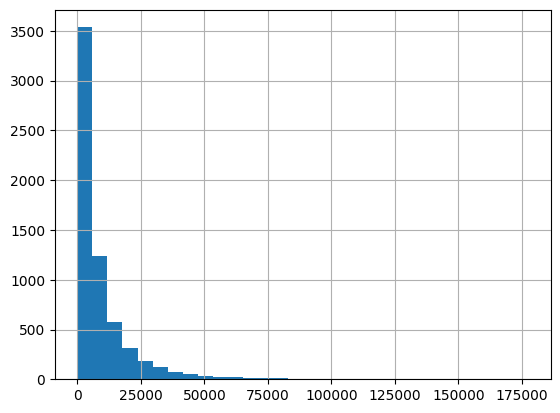

In [65]:
# Plot the distribution of the production
train_df_merged.production.hist(bins=30)

We can see it gets really skewed at the right, so we could try to normalize by computing the logarithm

<AxesSubplot:>

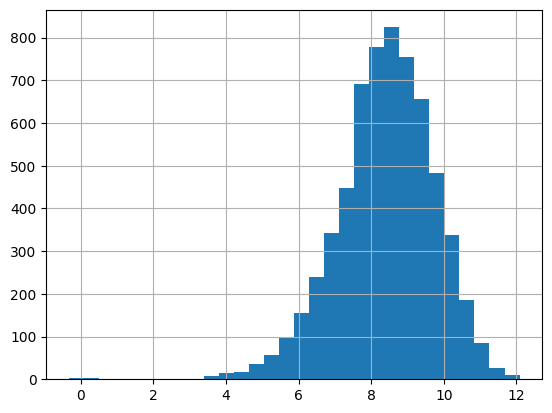

In [67]:
train_df_merged['production_log'] = np.log(train_df_merged['production'])
train_df_merged['production_log'].hist(bins=30)

We can analyse also the basic columns that we had at the main train dataframe.

<AxesSubplot:xlabel='type', ylabel='production_log'>

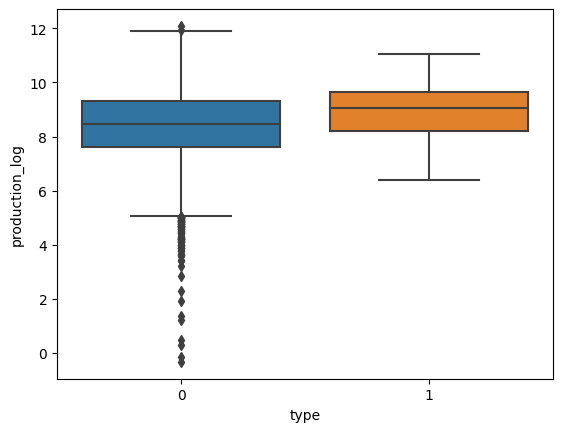

In [96]:
# We can see that for the type of 0, it tends to have at least more variety
sns.boxplot(x='type', y='production_log', data=train_df_merged)

We were able to extract a lot of information, but not all of it will be useful to explore and analyze.

There are a lot of columns, and some of them have NaNs.

In [69]:
train_df_merged.shape

(7176, 384)

In [80]:
# Could try a first filter and columns where > 30% of them are nulls
train_df_explore = train_df_merged.loc[:, train_df_merged.isnull().mean() < .3]

In [81]:
# We can see that for some columns it has worked
train_df_explore.shape

(7176, 330)

In [112]:
# We can handle the values that are missing by replacing by the previous valid one
train_df_explore = train_df_explore.sort_values(['id_finca', 'campaing'])

# We want to backfill all columns except the production ones
Y_train_df_explore = train_df_explore[['production', 'production_log']]
X_train_df_explore = train_df_explore.drop(['production', 'production_log'], axis=1)
X_train_df_explore.head(3)

,campaing,id_finca,id_zone,id_station,altitude,variety,type,color,surface,mode,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
4964,2015,200,86,12,482.5,59,0,1,0.37,1,...,1.788710,1.968649,2.634054,1.418378,2.181720,3.411828,1.412903,1.876882,2.242473,1.504839
2653,2016,200,86,12,482.5,59,0,1,0.37,1,...,2.181421,2.678689,3.527322,2.016120,2.673497,4.116120,1.786066,2.343989,2.763388,1.935246
4532,2017,200,86,12,482.5,59,0,1,0.37,1,...,2.174247,2.874795,3.737534,2.073973,2.686301,4.110959,1.730137,2.411507,2.885479,1.964932


Quick solution for handling the NaNs is to for a certain id_finca, to fill with the previous/next value for that finca.

In [115]:
X_train_df_handled = pd.DataFrame(
    columns=X_train_df_explore.columns.values,
    index=X_train_df_explore.index.values
)

In [116]:
unique_id_finca = X_train_df_explore.id_finca.unique()

In [143]:
for id_finca in unique_id_finca:
    finca_df = X_train_df_explore[X_train_df_explore.id_finca == id_finca]
    
    # Backward filling and forward filling
    finca_filled_df = finca_df.fillna(method='bfill').fillna(method='ffill')
    
    # And if not, fill numeric with the mean of the columns
    if sum(finca_filled_df.isnull().any()) > 0:
        finca_filled_int = finca_filled_df.select_dtypes(np.number).columns.values
        finca_filled_df[finca_filled_int] = finca_filled_df[finca_filled_int]\
            .apply(lambda x: x.fillna(x.mean()), axis=0)
    
    # For the categorical ones
    if sum(finca_filled_df.isnull().any()) > 0:
        finca_filled_df.fillna('Undefined', inplace=True)
    
    # Will fill the nans with the value before if possible, if not the next one, if not 0
    X_train_df_handled.loc[
        finca_df.index.values,
        :
    ] = finca_filled_df

In [ ]:
np.cat

## Data Processing

- Handling the NaNs
- Creating the mean features

## Data Engineering